In [4]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import kagglehub
from typing import List
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import math
from typing import List, Tuple
from collections import Counter
import seaborn as sns

c:\Users\billy\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Download latest version of the dataset
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

In [6]:
train_df_path =  os.path.join(path, "Train.csv")
test_df_path =  os.path.join(path, "Test.csv")
train_img_path =  os.path.join(path, "Train")
test_img_path =  os.path.join(path, "Test")

In [7]:
train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)

In [8]:
class_names = {
    0:"Speed Limit (20Km/hr)", 1:"Speed Limit (30Km/hr)", 
    2:"Speed Limit (50Km/hr)", 3: "Speed Limit (60Km/hr)", 
    4: "Speed Limit (70Km/hr)", 5: "Speed Limit (80Km/hr)",
    6: "End of Speed Limit (80Km/hr)", 7: "Speed Limit (100Km/hr)", 
    8: "Speed Limit (120Km/hr)", 9: "No Passing", 
    10: "No Passing for trucks over 3.5 tons", 11: "Right of way", 
    12: "Priotity Road", 13: "Yeild right of way",
    14: "Stop", 15: "Prohibited for all vehicles",
    16: "Trucks and tractors over 3.5 tons prohibited", 17: "Entery prohibited",
    18: "Danger", 19: "Single curve left",
    20: "Single curve right", 21: "Double curve",
    22: "Rough road", 23: "Slippery road",
    24: "Road narrows", 25: "Construction side ahead",
    26: "Signal lights ahead", 27: "Pedestrian crosswalk ahead",
    28: "Children", 29: "Bicycle crossing",
    30: "Unexpected ice danger", 31: "Wild animal crossing",
    32: "End of restrection", 33: "Mandatory direction of travel right",
    34: "Mandatory direction of travel left", 35: "Mandatory direction of travel ahead",
    36: "Straight or right", 37: "Straight or left",
    38: "Keep right", 39: "Keep left",
    40: "Traffic circle", 41: "End of no passing zone cars",
    42: "End of no passing zone vehicle over 3.5 tons"
}

train_df["ClassName"] = train_df['ClassId'].map(class_names)
test_df["ClassName"] = test_df['ClassId'].map(class_names)

In [ ]:
classes = sorted(os.listdir(train_img_path))
image_count = {}
half_dataset = []  # final list of selected images

for c in classes:
    folder = os.path.join(train_img_path, c)
    files = os.listdir(folder)

    # count images like your EDA
    image_count[c] = len(files)

    # take 50% of the images in this class
    half = len(files) // 2
    selected = np.random.choice(files, half, replace=False)

    # store full paths
    for f in selected:
        half_dataset.append(os.path.join(folder, f))

Number of classes: 43


In [2]:
import torch
from torchvision import transforms
from torchvision.models import EfficientNet_B0_Weights
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

#validation test transform (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [11]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

class GTSRBDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = Path(root_dir)      # <-- convert to Path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.root_dir / row["Path"]   # Path object
        img = Image.open(img_path).convert("RGB")
        label = int(row["ClassId"])

        if self.transform:
            img = self.transform(img)
        return img, label

test_dataset = GTSRBDataset(test_df, root_dir=path, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

print(f"Test loader: {len(test_loader)} batches")

Test loader: 198 batches


In [15]:
os.getcwd()
os.chdir("C:/Users/billy/DataScienceToolbox-Project2")
print(os.listdir())

['.DS_Store', '.git', 'Adlan', 'Billy', 'Gracie', 'Leo', 'Neva', 'README.md', 'Report']


In [16]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

NUM_CLASSES = 43

# Load EfficientNet base model
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
base_model = efficientnet_b0(weights=weights)

# Remove classifier → keep global avg pooling only
base_model.classifier = nn.Identity()

# Freeze base model
for param in base_model.parameters():
    param.requires_grad = False

# Build the same custom head Neva used
model = nn.Sequential(
    base_model,                # (0)
    nn.Linear(1280, 256),      # (2)
    nn.ReLU(),                 # (3)
    nn.Dropout(0.4),           # (4)
    nn.Linear(256, NUM_CLASSES),  # (5)
    nn.Softmax(dim=1)          # (6)
)

# Load the saved weights
state_dict = torch.load("Neva/efficientnet_finetuned.pth", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

Sequential(
  (0): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activati

In [17]:
from torchvision.models import ResNet50_Weights
from torchvision import models

model_resnet18 = models.resnet18(weights=None)
model_resnet18.fc = torch.nn.Linear(512, 43)   # example for 43 traffic signs
state_dict_resnet18 = torch.load("Gracie/resnet18_traffic_signs.pth", map_location="cpu")
model_resnet18.load_state_dict(state_dict_resnet18)
model_resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
class_names = test_loader.dataset.class_names if hasattr(test_loader.dataset, 'class_names') else class_names
print(class_names)

{0: 'Speed Limit (20Km/hr)', 1: 'Speed Limit (30Km/hr)', 2: 'Speed Limit (50Km/hr)', 3: 'Speed Limit (60Km/hr)', 4: 'Speed Limit (70Km/hr)', 5: 'Speed Limit (80Km/hr)', 6: 'End of Speed Limit (80Km/hr)', 7: 'Speed Limit (100Km/hr)', 8: 'Speed Limit (120Km/hr)', 9: 'No Passing', 10: 'No Passing for trucks over 3.5 tons', 11: 'Right of way', 12: 'Priotity Road', 13: 'Yeild right of way', 14: 'Stop', 15: 'Prohibited for all vehicles', 16: 'Trucks and tractors over 3.5 tons prohibited', 17: 'Entery prohibited', 18: 'Danger', 19: 'Single curve left', 20: 'Single curve right', 21: 'Double curve', 22: 'Rough road', 23: 'Slippery road', 24: 'Road narrows', 25: 'Construction side ahead', 26: 'Signal lights ahead', 27: 'Pedestrian crosswalk ahead', 28: 'Children', 29: 'Bicycle crossing', 30: 'Unexpected ice danger', 31: 'Wild animal crossing', 32: 'End of restrection', 33: 'Mandatory direction of travel right', 34: 'Mandatory direction of travel left', 35: 'Mandatory direction of travel ahead', 

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)            
model_resnet18.to(device)

criterion = nn.CrossEntropyLoss()

correct_eff = 0          
correct_res = 0          
top5_correct_eff = 0
top5_correct_res = 0
total = 0

running_loss_eff = 0.0
running_loss_res = 0.0

all_labels = []
all_pred_eff = []
all_pred_res = []

model.eval()
model_resnet18.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # EfficientNet 
        outputs = model(images)
        loss_eff = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        _, top5_predicted = torch.topk(outputs, 5, dim=1)

        # ResNet18 
        outputs_resnet18 = model_resnet18(images)
        loss_res = criterion(outputs_resnet18, labels)
        _, predicted_resnet18 = torch.max(outputs_resnet18, 1)
        _, top5_predicted_resnet18 = torch.topk(outputs_resnet18, 5, dim=1)

        total += labels.size(0)

        correct_eff += (predicted == labels).sum().item()
        correct_res += (predicted_resnet18 == labels).sum().item()
        top5_correct_eff += sum([1 if labels[i] in top5_predicted[i] else 0 for i in range(labels.size(0))])
        top5_correct_res += sum([1 if labels[i] in top5_predicted_resnet18[i] else 0 for i in range(labels.size(0))])
        running_loss_eff += loss_eff.item() * labels.size(0)
        running_loss_res += loss_res.item() * labels.size(0)

        # store for later metrics
        all_labels.append(labels.cpu().numpy())
        all_pred_eff.append(predicted.cpu().numpy())
        all_pred_res.append(predicted_resnet18.cpu().numpy())

accuracy_eff = 100 * correct_eff / total
top5_accuracy_eff = 100 * top5_correct_eff / total
accuracy_res = 100 * correct_res / total
top5_accuracy_res = 100 * top5_correct_res / total

avg_loss_eff = running_loss_eff / total
avg_loss_res = running_loss_res / total

print(f"Test Accuracy for EfficientNet: {accuracy_eff:.2f}%  | Top-5: {top5_accuracy_eff:.2f}% | Loss: {avg_loss_eff:.4f}")
print(f"Test Accuracy for ResNet18:     {accuracy_res:.2f}%  | Top-5: {top5_accuracy_res:.2f}% | Loss: {avg_loss_res:.4f}")

# concatenate all for further analysis
y_true = np.concatenate(all_labels)
y_pred_eff = np.concatenate(all_pred_eff)
y_pred_res = np.concatenate(all_pred_res)

Test Accuracy for EfficientNet: 73.13%  | Top-5: 78.71% | Loss: 3.0699
Test Accuracy for ResNet18:     68.36%  | Top-5: 93.56% | Loss: 1.0516


In [ ]:
from sklearn.metrics import classification_report

def classification_report_model(model, test_loader, device):
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # structured dict instead of text
    report_dict = classification_report(all_labels, all_preds, zero_division=0, output_dict=True)

    # convert dict to DataFrame
    df_metrics = pd.DataFrame(report_dict).transpose()

    return df_metrics, all_labels, all_preds

In [51]:
from sklearn.metrics import confusion_matrix
df_effnet, true_effnet, pred_effnet = classification_report_model(model, test_loader, device)
cm = confusion_matrix(true_effnet, pred_effnet)

In [60]:
print(df_effnet)

              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000     60.000000
1              0.873323  0.813889  0.842559    720.000000
2              0.704339  0.930667  0.801838    750.000000
3              0.954930  0.753333  0.842236    450.000000
4              0.853425  0.943939  0.896403    660.000000
5              0.739329  0.769841  0.754277    630.000000
6              0.798611  0.766667  0.782313    150.000000
7              0.948598  0.902222  0.924829    450.000000
8              0.873614  0.875556  0.874584    450.000000
9              0.772727  0.991667  0.868613    480.000000
10             0.840206  0.987879  0.908078    660.000000
11             0.000000  0.000000  0.000000    420.000000
12             0.944598  0.988406  0.966006    690.000000
13             0.857314  0.993056  0.920206    720.000000
14             0.967391  0.988889  0.978022    270.000000
15             0.995122  0.971429  0.983133    210.000000
16            

In [58]:
df_resnet, true_resnet, pred_resnet = classification_report_model(model_resnet18, test_loader, device)
cm_resnet = confusion_matrix(true_resnet, pred_resnet)

{'0': {'precision': 0.21568627450980393, 'recall': 0.18333333333333332, 'f1-score': 0.1981981981981982, 'support': 60.0}, '1': {'precision': 0.6406480117820325, 'recall': 0.6041666666666666, 'f1-score': 0.6218727662616155, 'support': 720.0}, '2': {'precision': 0.4795821462488129, 'recall': 0.6733333333333333, 'f1-score': 0.5601774819744869, 'support': 750.0}, '3': {'precision': 0.4249471458773784, 'recall': 0.44666666666666666, 'f1-score': 0.4355362946912243, 'support': 450.0}, '4': {'precision': 0.7813021702838063, 'recall': 0.7090909090909091, 'f1-score': 0.7434471803018269, 'support': 660.0}, '5': {'precision': 0.6202143950995406, 'recall': 0.6428571428571429, 'f1-score': 0.6313328137178488, 'support': 630.0}, '6': {'precision': 0.9076923076923077, 'recall': 0.7866666666666666, 'f1-score': 0.8428571428571429, 'support': 150.0}, '7': {'precision': 0.7609756097560976, 'recall': 0.6933333333333334, 'f1-score': 0.7255813953488373, 'support': 450.0}, '8': {'precision': 0.7103960396039604

In [59]:
print(df_resnet)

              precision    recall  f1-score      support
0              0.215686  0.183333  0.198198     60.00000
1              0.640648  0.604167  0.621873    720.00000
2              0.479582  0.673333  0.560177    750.00000
3              0.424947  0.446667  0.435536    450.00000
4              0.781302  0.709091  0.743447    660.00000
5              0.620214  0.642857  0.631333    630.00000
6              0.907692  0.786667  0.842857    150.00000
7              0.760976  0.693333  0.725581    450.00000
8              0.710396  0.637778  0.672131    450.00000
9              0.776181  0.787500  0.781799    480.00000
10             0.783824  0.807576  0.795522    660.00000
11             0.762763  0.604762  0.674635    420.00000
12             0.936842  0.902899  0.919557    690.00000
13             0.989130  0.884722  0.934018    720.00000
14             0.972868  0.929630  0.950758    270.00000
15             0.952381  0.952381  0.952381    210.00000
16             0.866197  0.8200

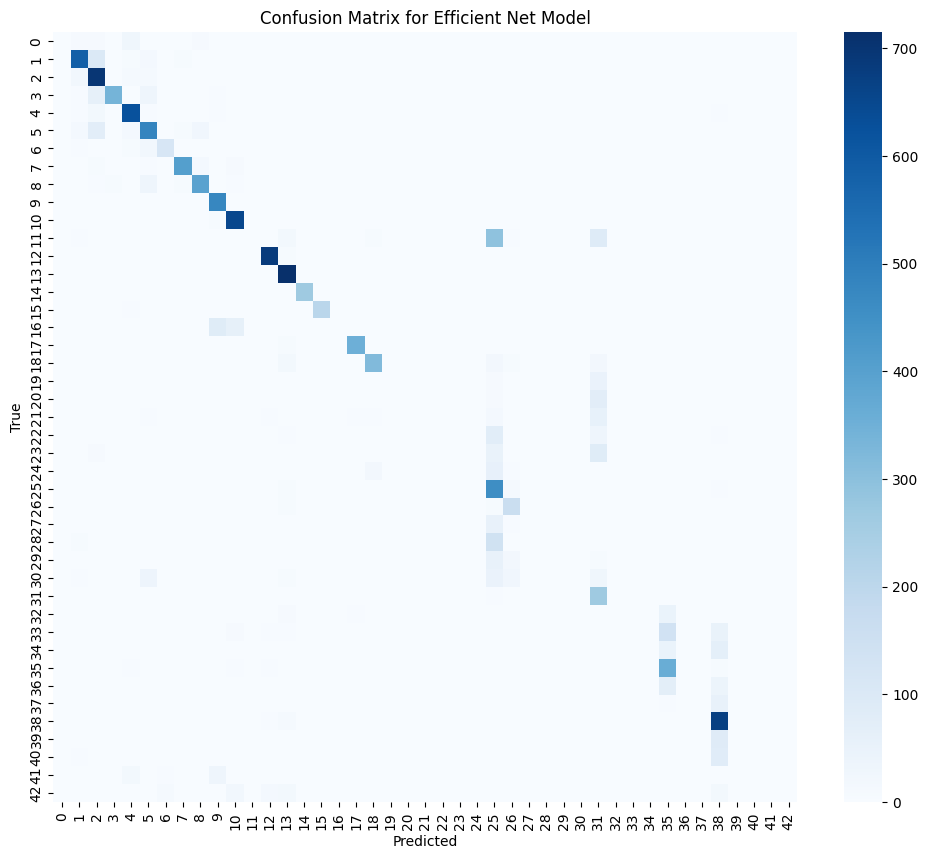

In [55]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Efficient Net Model")
plt.show()

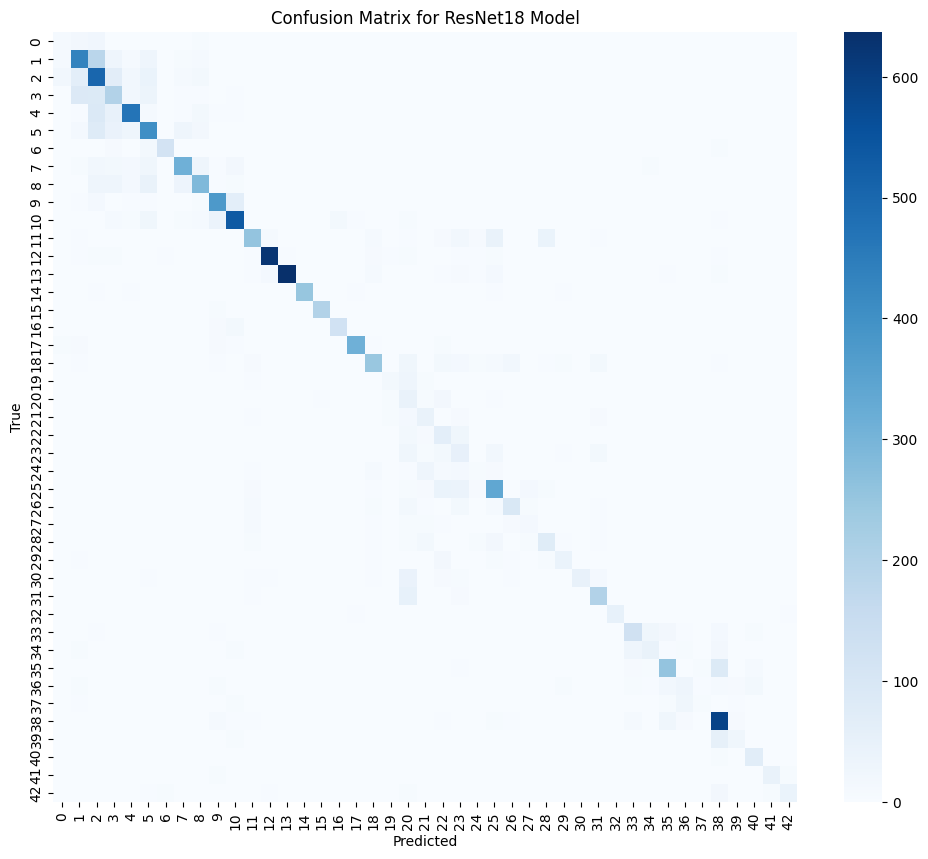

In [23]:
plt.figure(figsize=(12,10))
sns.heatmap(cm_resnet, annot=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for ResNet18 Model")
plt.show()

In [67]:
precision_eff = df_effnet.loc["weighted avg", "precision"]
recall_eff = df_effnet.loc["weighted avg", "recall"]
f1_eff = df_effnet.loc["weighted avg", "f1-score"]

precision_res = df_resnet.loc["weighted avg", "precision"]
recall_res = df_resnet.loc["weighted avg", "recall"]
f1_res = df_resnet.loc["weighted avg", "f1-score"]

print(f"EfficientNet - Macro Precision: {precision_eff:.4f}, Macro Recall: {recall_eff:.4f}, Macro F1-Score: {f1_eff:.4f}\n")
print(f"ResNet18   - Macro Precision: {precision_res:.4f}, Macro Recall: {recall_res:.4f}, Macro F1-Score: {f1_res:.4f}")

EfficientNet - Macro Precision: 0.6283, Macro Recall: 0.7313, Macro F1-Score: 0.6645

ResNet18   - Macro Precision: 0.7069, Macro Recall: 0.6836, Macro F1-Score: 0.6884


In [68]:
worst_classes_eff= df_effnet.iloc[:-3].sort_values("recall").head(5)
worst_classes_res= df_resnet.iloc[:-3].sort_values("recall").head(5)

print(worst_classes_eff, "\n")
print(worst_classes_res)

    precision  recall  f1-score  support
0         0.0     0.0       0.0     60.0
11        0.0     0.0       0.0    420.0
23        0.0     0.0       0.0    150.0
22        0.0     0.0       0.0    120.0
20        0.0     0.0       0.0     90.0 

    precision    recall  f1-score  support
24   0.111111  0.066667  0.083333     90.0
37   0.285714  0.100000  0.148148     60.0
0    0.215686  0.183333  0.198198     60.0
27   0.282609  0.216667  0.245283     60.0
36   0.386667  0.241667  0.297436    120.0


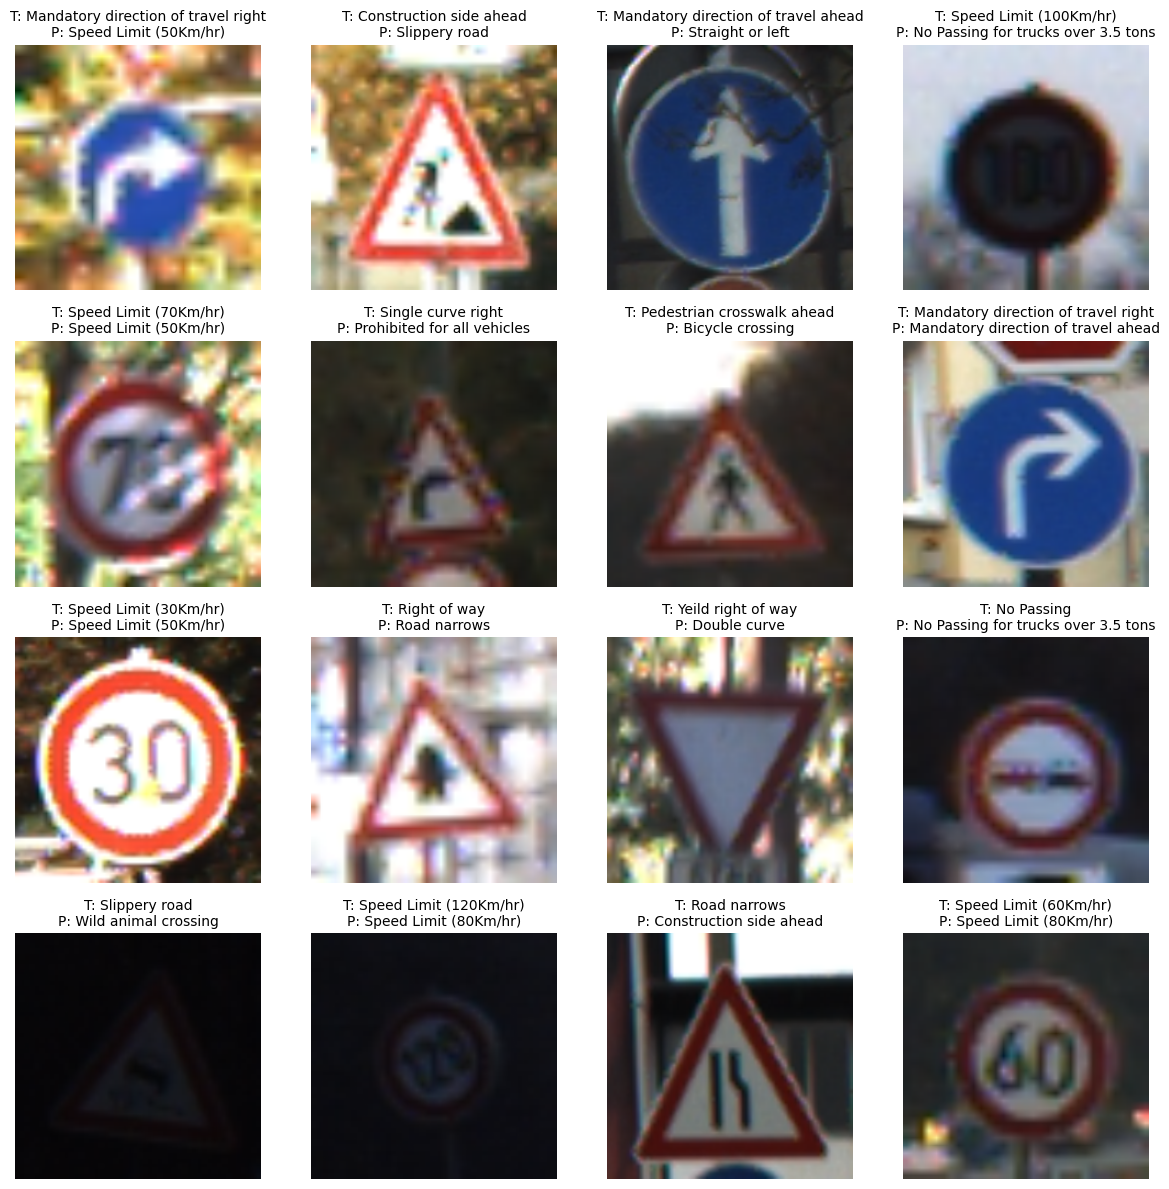

In [69]:
import matplotlib.pyplot as plt
import torch

def show_misclassified(model, loader, device, class_names, max_images=16):
    model.eval()
    misclassified = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images).argmax(1)
            
            for img, true, pred in zip(images[preds != labels], 
                                       labels[preds != labels], 
                                       preds[preds != labels]):
                misclassified.append((img.cpu(), true.item(), pred.item()))
                if len(misclassified) >= max_images:
                    break
            if len(misclassified) >= max_images:
                break
    
    # Setup plot
    n = len(misclassified)
    cols = 4
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten() if n > 1 else [axes]
    
    # Denormalization constants
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # Plot each misclassified image
    for i, (img, true, pred) in enumerate(misclassified):
        img = ((img * std + mean).permute(1, 2, 0).clamp(0, 1))
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"T: {class_names[true]}\nP: {class_names[pred]}", 
                          fontsize=10)
    
    # Hide unused subplots
    for i in range(n, len(axes)):
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

# Test it
show_misclassified(model_resnet18, test_loader, device, class_names)

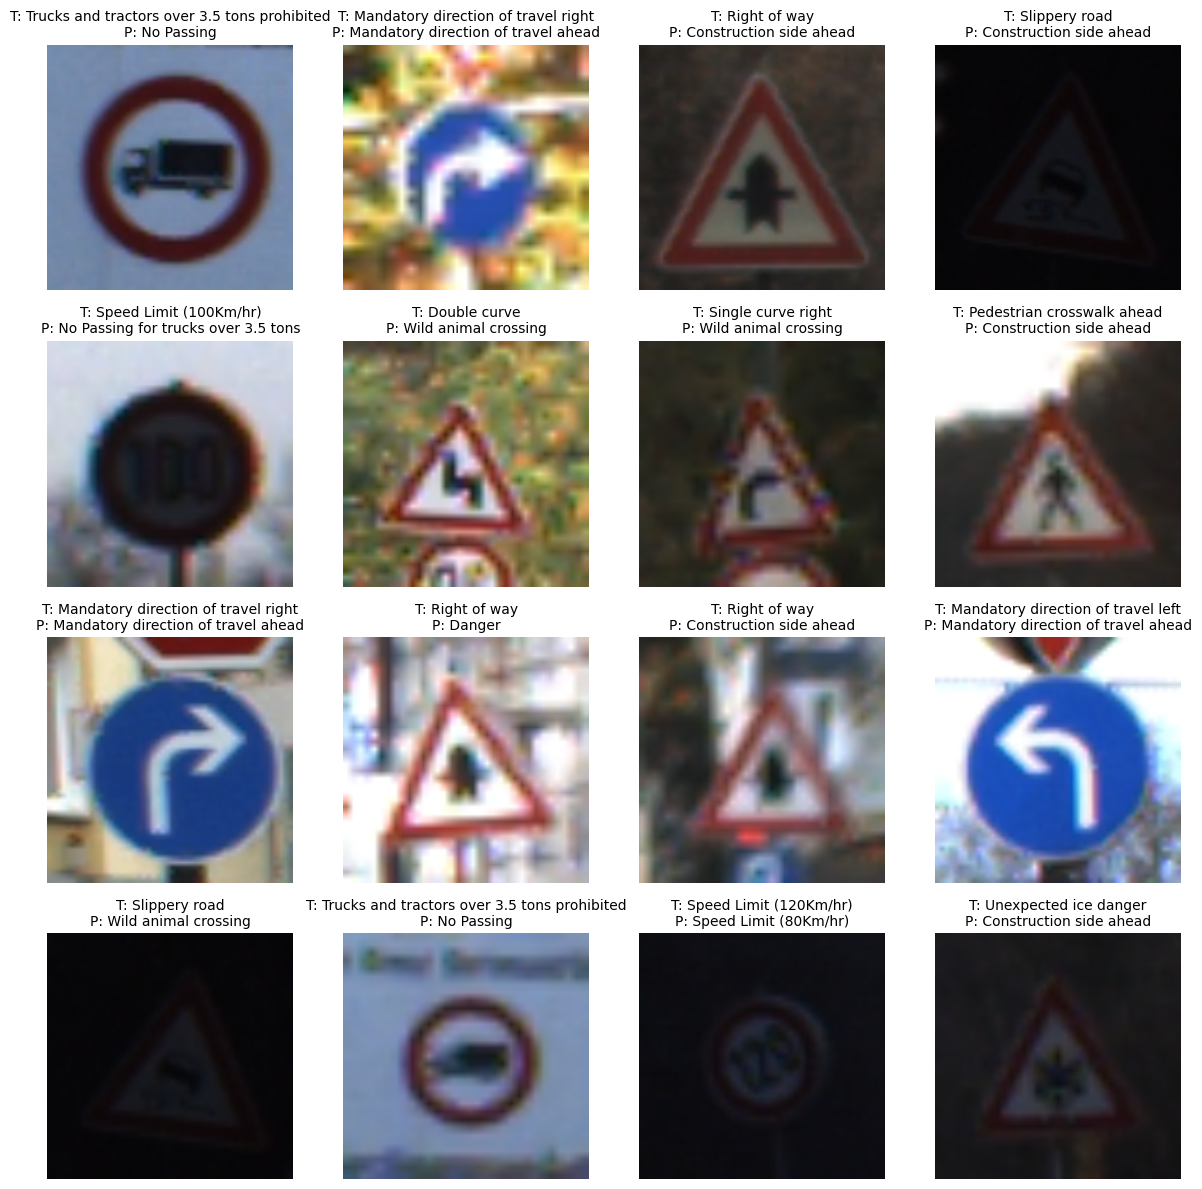

In [70]:
show_misclassified(model, test_loader, device, class_names)

In [71]:
both_correct = (y_pred_eff == y_true) & (y_pred_res == y_true)
eff_only     = (y_pred_eff == y_true) & (y_pred_res != y_true)
res_only     = (y_pred_eff != y_true) & (y_pred_res == y_true)
both_wrong   = (y_pred_eff != y_true) & (y_pred_res != y_true)

print(f"Samples both correct:    {both_correct.sum()}")
print(f"EfficientNet only right: {eff_only.sum()}")
print(f"ResNet18 only right:     {res_only.sum()}")
print(f"Both wrong:              {both_wrong.sum()}")

Samples both correct:    7150
EfficientNet only right: 2086
ResNet18 only right:     1484
Both wrong:              1910


In [38]:
import time

def measure_latency(model, dataloader, n_batches=10):
    model.eval()
    model.to(device)
    times = []

    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            if i >= n_batches:
                break
            images = images.to(device)

            torch.cuda.synchronize() if device.type == "cuda" else None
            t0 = time.perf_counter()
            _ = model(images)
            torch.cuda.synchronize() if device.type == "cuda" else None
            t1 = time.perf_counter()

            times.append((t1 - t0) / images.size(0))  # seconds / image

    return np.mean(times), np.std(times)

mean_eff, std_eff = measure_latency(model, test_loader)
mean_res, std_res = measure_latency(model_resnet18, test_loader)

print(f"EfficientNet: {mean_eff*1000:.2f} ± {std_eff*1000:.2f} ms / image")
print(f"ResNet18:     {mean_res*1000:.2f} ± {std_res*1000:.2f} ms / image")

EfficientNet: 31.20 ± 7.74 ms / image
ResNet18:     21.88 ± 1.00 ms / image
